### Cross Validation
Instead of saving the inner products $(X_i, r_j)$, we will save the deleted inner products $(\hat{X}_i, \hat{r}_j)$. We do this by simply removing all the entries of $X$ that are in our delete set $K$. However, we need to account for the "jump". If we skip timesteps $k_1, \ldots, k_K$, we need to remove the entry that contributes to the jump, so $(\h

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from timeit import default_timer as timer

import sys
sys.path.append("..")

import helper.helper as h
import helper.methods as m

from notears.notears.notears import utils 

from importlib import reload  # Python 3.4+
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

### Generate Data

[[0.6348263  0.         0.         0.         0.        ]
 [1.41639104 0.86270219 0.         0.         0.        ]
 [0.         0.         0.90255918 0.         0.        ]
 [0.         1.24099902 0.         0.         0.        ]
 [1.19917462 1.4596496  0.75370057 1.281063   0.5895422 ]]


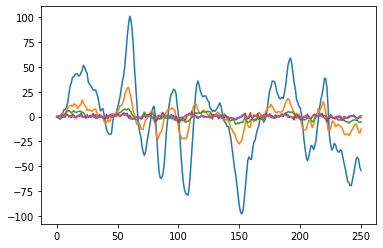

In [151]:
p, s, T = 5, 10, 251
A_true = np.abs(h.generate_A(p, s))
print(A_true)
X = h.generate_var_2(T, p, A_true, np.identity(p))
plt.plot(X);

### Create Features / Atoms and Labels / Residuals

In [152]:
def normalize(x): return x / np.linalg.norm(x)

# compute atoms, residuals
W = np.zeros((p, p))
atoms = np.array([X[:-1, i] for i in range(p)])
residuals = np.array([X[1:, j] for j in range(p)])

# double check, gains of first iteration
gains = np.array([np.abs(normalize(X[:-1, i]) @ ((X @ W)[:-1, j] - X[1:, j])) for j in range(p) for i in range(p)])
print(np.shape(gains))

# inner product without summation, could be useful before removing
print(np.shape([(atoms[i,:] * residuals[j,:]) for i in range(p) for j in range(p)]))

(25,)
(25, 250)


### Kernel OMP

In [153]:
def K_OMP(Psi, K, Theta, X, max_coefs = 1e10, tol = 0.0, tol_res = 0.0, verbose = False, output = False, normalize = False, F = [], is_sem = False):
    """Do Kernel OMP on X, Y."""

    def Lambda_to_adj(Lambda):
        """Convert Lambda list to adjacency matrix"""
        n = len(Lambda)
    
        adj_mat = np.zeros((n, n))
    
        for i, col in enumerate(Lambda):
            adj_mat[i, col] = 1 
    
        return adj_mat
    
    # get dimensions
    n = np.shape(Psi)[0]

    if is_sem: F = [i * (n + 1) for i in range(n)]
    
    # initialize Lambda, idx, betas
    Lambda, idx, betas, Ws = [[] for _ in range(n)], [], np.zeros((n, n)), []
    
    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array
    if normalize: norms = [np.linalg.norm(x) for x in X]

    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        # set forbidden set to -1, impossible to pick then
        gains = gains.flatten()
        
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(n, n)
        # stopping criterion
        # print(np.round(gains.max(), 1), end = "\t")
        if np.round(gains, 8).max() <= tol: 
            break

        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n

        if row not in Lambda[col]: Lambda[col].append(row)
        else: print("A")
    
        # check if we have a DAG, not super efficient
        if h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # speedup: add transpose to forbidden set
            F.append(col * n + row)
            F.append(row * n + col)
            
            # update betas
            betas[np.array(idx)[:, None], col] = np.linalg.pinv(Psi_F) @ K[np.array(idx)[:, None], col]
            
            Ws.append(betas.copy())
            
            # print(np.round(betas[row][col], 1), end = "\t")
            # if np.abs(betas[row][col]) <= tol: break
            if len(np.nonzero(betas)[0]) >= max_coefs: break
            
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
#         # check residual squared
#         print(sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]))
#         print(row, col)

        if sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]) < tol_res:
            print("Residual Limit, terminate")
            break

        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas, Ws, sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)])


### Train on Part of Data

In [154]:
# k: range to remove
k = range(0, T // 10)
atoms_del = np.delete(atoms, k, axis = 1)
residuals_del = np.delete(residuals, k, axis = 1)

# compute K, psi
K = np.dot(atoms_del, residuals_del.T)

print(np.shape(atoms_del.dot(atoms_del.T)))
print(np.shape(np.abs(atoms_del.dot(residuals_del.T))))

# inner product without summation
print(np.shape([(atoms_del[i,:] * residuals_del[j,:]) for i in range(p) for j in range(p)]))

# do OMP on Psi and K
W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [])
print(np.round(W, 1))

(5, 5)
(5, 5)
(25, 225)
[[ 0.6  0.   0.   0.   0. ]
 [ 1.4  0.9 -0.   0.   0. ]
 [ 0.   0.   0.8  0.   0. ]
 [-0.   1.3  0.1  0.   0. ]
 [ 1.2  1.4  0.7  1.3  0.6]]


In [146]:
# indices to remove, large part
k = range(5, T - 5)
atoms_del = np.delete(atoms, k, axis = 1)
residuals_del = np.delete(residuals, k, axis = 1)

# do OMP on Psi and K
W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [])
print(np.round(Ws[5], 1))
print(A_true)
print(h.score(X, W, A_true))

[[0.9 0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0. ]
 [1.4 1.8 0.  0.  0. ]
 [0.  1.2 0.  0.6 0. ]
 [0.  0.  0.  0.  0. ]]
[[0.88232787 0.         0.         0.         0.        ]
 [0.82349962 0.         0.         0.         0.        ]
 [0.88951307 1.33052602 0.         0.         0.        ]
 [0.96587207 1.1215218  0.         0.77863391 0.        ]
 [0.         0.63853803 1.20283455 1.93410812 0.        ]]
True Positive Rate: 1.0.
True Negative Rate: 0.667.
False Prediction Rate: 0.333
Accuracy: 0.8.
R-Squared: 0.99
Mean Squared Error: 13.155
(1.0, 0.6666666666666666, 0.3333333333333333, 0.8, 5, 13.154618373796563, 0.9896166356203171)


In [155]:
# full part
W, Ws, _ = K_OMP(X[:-1].T.dot(X[:-1]), X[:-1].T.dot(X[1:]), [np.dot(y.T, y) for y in X[1:].T], X[:-1].T, normalize = True, F = [], tol = -0.99)
print(np.round(W, 1))

for W in Ws:
    print(np.round(W, 1))

[[ 0.6  0.   0.   0.   0. ]
 [ 1.4  0.9 -0.   0.   0. ]
 [ 0.   0.   0.8  0.   0. ]
 [ 0.   1.3  0.1  0.   0. ]
 [ 1.2  1.4  0.7  1.3  0.6]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[1.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [2.7 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[1.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  0.9 0.  0. ]
 [2.7 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[1.  0.  0.  0.  0. ]
 [0.  0.9 0.  0.  0. ]
 [0.  0.  0.9 0.  0. ]
 [2.7 1.7 0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.6 0.  0.  0.  0. ]
 [1.4 0.9 0.  0.  0. ]
 [0.  0.  0.9 0.  0. ]
 [0.3 1.7 0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.6 0.  0.  0.  0. ]
 [1.4 0.9 0.  0.  0. ]
 [0.  0.  0.9 0.  0. ]
 [0.3 1.7 0.  0.  0. ]
 [0.  0.  0.  1.3 0. ]]
[[0.6 0.  0.  0.  0. ]
 [1.4 0.9 0.  0.  0. ]
 [0.  0.  0.9 0.  0. ]
 [0.3 1.3 0.  0.  0. ]
 [0. 

### $k$-Fold Cross-Validating

Remove X-Y pairs 0 until 124.	Remove X-Y pairs 125 until 249.	Remove X-Y pairs 0 until 0.	Remove X-Y pairs 1 until 1.	Remove X-Y pairs 2 until 2.	Remove X-Y pairs 3 until 3.	Remove X-Y pairs 4 until 4.	Remove X-Y pairs 5 until 5.	Remove X-Y pairs 6 until 6.	Remove X-Y pairs 7 until 7.	Remove X-Y pairs 8 until 8.	Remove X-Y pairs 9 until 9.	Remove X-Y pairs 10 until 10.	Remove X-Y pairs 11 until 11.	Remove X-Y pairs 12 until 12.	Remove X-Y pairs 13 until 13.	Remove X-Y pairs 14 until 14.	Remove X-Y pairs 15 until 15.	Remove X-Y pairs 16 until 16.	Remove X-Y pairs 17 until 17.	Remove X-Y pairs 18 until 18.	Remove X-Y pairs 19 until 19.	Remove X-Y pairs 20 until 20.	Remove X-Y pairs 21 until 21.	Remove X-Y pairs 22 until 22.	Remove X-Y pairs 23 until 23.	Remove X-Y pairs 24 until 24.	Remove X-Y pairs 25 until 25.	Remove X-Y pairs 26 until 26.	Remove X-Y pairs 27 until 27.	Remove X-Y pairs 28 until 28.	Remove X-Y pairs 29 until 29.	Remove X-Y pairs 30 until 30.	Remove X-Y pairs 31 until 31

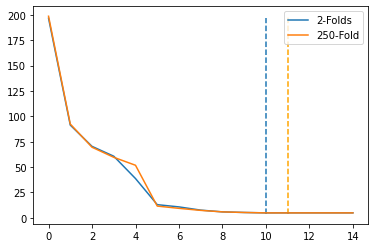

In [156]:
def k_fold_cross_validation(num_splits):
    mses_avg = []
    
    # for each split
    for i in range(num_splits):
        
        # get numbers to remove
        k = range(i * T // num_splits, min((i + 1) * T // num_splits, T - 1))
        print(f"Remove X-Y pairs {k[0]} until {k[-1]}.", end = "\t")
        
        # if length 2, delete, do OMP, remove
        if len(k) >= 2:
            atoms_del = np.delete(atoms, k, axis = 1)
            residuals_del = np.delete(residuals, k, axis = 1)
            W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [], tol = -0.99)
    
            mses_avg.append([1 / (len(k)) * np.linalg.norm(X[k[1:]] - X[k[:-1]] @ W, 'f') ** 2 for W in Ws])

        elif len(k) == 1 and k[0] > 0:
            atoms_del = np.delete(atoms, k, axis = 1)
            residuals_del = np.delete(residuals, k, axis = 1)
            W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [], tol = -0.99)
    
            mses_avg.append([np.linalg.norm(X[k[0] + 1] - X[k[0]] @ W, 2) ** 2 for W in Ws])
            # print(round(np.linalg.norm(X[k[1:]] - X[k[:-1]] @ W, 2) ** 2), end = "\t")
    
    return mses_avg

num_splits = T - 1
two_fold_mses = k_fold_cross_validation(2)
more_fold_mses = k_fold_cross_validation(num_splits)

print(np.shape(two_fold_mses), np.shape(more_fold_mses))
# plot results
plt.vlines(np.argmin(np.mean(np.array(two_fold_mses), axis = 0)), min(np.mean(np.array(two_fold_mses), axis = 0)) - 1, max(np.mean(np.array(two_fold_mses), axis = 0)), linestyle = "--")
plt.plot(np.mean(np.array(two_fold_mses), axis = 0), label = "2-Folds")

plt.vlines(np.argmin(np.mean(np.array(more_fold_mses), axis = 0)), min(np.mean(np.array(more_fold_mses), axis = 0)) - 1, max(np.mean(np.array(more_fold_mses), axis = 0)), linestyle = "--", color = "orange")
plt.plot(np.mean(np.array(more_fold_mses), axis = 0), label = f"{num_splits}-Fold")
plt.legend()

### Oracle Knowledge: Expected Cost Var
$$\begin{align*}R(f) &= \text{Tr}\left(\mathbb{E}\left[(Y - f(X))^2\right]\right) \\&= \text{Tr}\left(\mathbb{E}\left[(Y - XW)^2\right]\right) \\  &=  \text{Tr}\left(\mathbb{E}\left[\left(\Sigma + XW^* - XW\right)^2\right]\right)  \\ &= \text{Tr}\left(\mathbb{E}\left[\left(\Sigma + X\left(W^* - W\right)\right)^2\right]\right) \\ &= \text{Tr}\left(\Sigma + \left(W - W^*\right)^T \mathbb{E}\left[X^2\right] \left(W - W^*\right)\right).\end{align*}$$


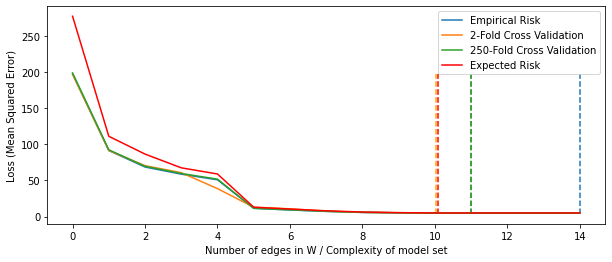

In [157]:
covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(A_true.T, A_true.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
W, Ws, _ = K_OMP(X[:-1].T.dot(X[:-1]), X[:-1].T.dot(X[1:]), [np.dot(y.T, y) for y in X[1:].T], X[:-1].T, normalize = True, F = [], tol = -0.99)

def expected_cost_var(W_true, W_est, Sigma = np.identity(p)):
    
    # base on the distribution of X, no actual data needed.    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W_true.T, W_true.T)), Sigma.reshape(p ** 2)).reshape((p, p))
    
    # covariance matrix
    covariance_matrix = Sigma + np.matmul((W_true - W_est).T, np.matmul(covariance_X.T, (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

plt.figure(figsize = (10, 4))
l_lim = 0
min_vlines = np.min((np.array([expected_cost_var(A_true, W) for W in Ws[l_lim:]]), np.mean(np.array(two_fold_mses), axis = 0)[l_lim:]))
max_vlines = np.max((np.array([expected_cost_var(A_true, W) for W in Ws[l_lim:]]), np.mean(np.array(two_fold_mses), axis = 0)[l_lim:]))

# Plot empirical risk, cross validated risk, true risk.
plt.plot([h.MSE(W, X) for W in Ws[l_lim:]], label = "Empirical Risk")
plt.plot(np.mean(np.array(two_fold_mses), axis = 0)[l_lim:], label = f"2-Fold Cross Validation")
plt.plot(np.mean(np.array(more_fold_mses), axis = 0)[l_lim:], label = f"{num_splits}-Fold Cross Validation")
plt.plot([expected_cost_var(A_true, W) for W in Ws[l_lim:]], label = "Expected Risk", color = "red")

# Show minimizers of empirical risk, cross validated risk, true risk
min_vlines = np.min((np.array([h.MSE(W, X) for W in Ws[l_lim:]]), np.mean(np.array(two_fold_mses), axis = 0)[l_lim:]))
max_vlines = np.max((np.array([h.MSE(W, X) for W in Ws[l_lim:]]), np.mean(np.array(two_fold_mses), axis = 0)[l_lim:]))
plt.vlines(np.argmin(np.array([h.MSE(W, X) for W in Ws[l_lim:]])), min_vlines - 1, max_vlines, linestyle = "--")
plt.vlines(np.argmin(np.mean(np.array(two_fold_mses), axis = 0)[l_lim:]) + 0.025, min_vlines - 1, max_vlines, color = "orange", linestyle = "--")
plt.vlines(np.argmin(np.mean(np.array(more_fold_mses), axis = 0)[l_lim:] + 0.050), min_vlines - 1, max_vlines, color = "g", linestyle = "--")
plt.vlines(np.argmin([expected_cost_var(A_true, W) for W in Ws[l_lim:]]) + 0.075, min_vlines - 1, max_vlines, color = "r", linestyle = "--")

# Show legend
plt.ylabel("Loss (Mean Squared Error)")
plt.xlabel("Number of edges in W / Complexity of model set")
plt.legend()

In [138]:
print(expected_cost_var(A_true, W))
print(h.MSE(W, h.generate_var_2(T * 5, p, A_true, np.identity(p))))

5.030716202789549
5.064466993433152


In [11]:
expected_cost = [expected_cost_var(A_true, W) for W in Ws]

In [12]:
mses = []
l_lim = 0
split_range = range(2, T - 1, 5)
for j in split_range:
    print(j, end = "\t")
    num_splits = j
    mses_avg = []
    for i in range(num_splits):
        k = range(i * T // num_splits, min((i + 1) * T // num_splits, T - 1))
        if len(k) >= 2:
            
            atoms_del = np.delete(atoms, k, axis = 1)
            residuals_del = np.delete(residuals, k, axis = 1)
            W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [])

            mses_avg.append([1 / (len(k) - 1) * np.linalg.norm(X[k[1:]] - X[k[:-1]] @ W, 2) ** 2 for W in Ws[l_lim:]])
        
        elif len(k) == 1 and k[0] > 0:
            atoms_del = np.delete(atoms, k, axis = 1)
            residuals_del = np.delete(residuals, k, axis = 1)
            W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [])
    
            mses_avg.append([np.linalg.norm(X[k[0] + 1] - X[k[0]] @ W, 2) ** 2 for W in Ws[l_lim:]])
        
    mses.append(np.mean(np.array(mses_avg), axis = 0))

for i, mse in enumerate(np.array(mses)):
    plt.plot(mse, label = f"{split_range[i]} folds")
# plt.plot(np.array(mses).T, labels = ["A", "B", "C", "D", "E"])
plt.plot([expected_cost_var(A_true, W) for W in Ws[l_lim:]], label = "Expected Cost", color = "black")
plt.legend()

2	7	12	17	22	27	32	

KeyboardInterrupt: 

In [ ]:
W_thresh = W.copy()
W_thresh[np.abs(W_thresh) <= 0.3] = 0
print(f"Empirical Risk Minimizer:\t{h.score(X, Ws[np.argmin(np.array([h.MSE(W, X) for W in Ws[l_lim:]]))], A_true, printing = False)[:5]}.")
print(f"Naive Risk Minimizer:\t\t{h.score(X, W_thresh, A_true, printing = False)[:5]}.")
print(f"Two Fold Risk Minimizer:\t{h.score(X, Ws[np.argmin(np.mean(np.array(two_fold_mses), axis = 0)[l_lim:])], A_true, printing = False)[:5]}.")
print(f"{num_splits} Fold Risk Minimizer:\t\t{h.score(X, Ws[np.argmin(np.mean(np.array(more_fold_mses), axis = 0)[l_lim:])], A_true, printing = False)[:5]}.")
print(f"Expected Risk Minimizer: \t{h.score(X, Ws[np.argmin([expected_cost_var(A_true, W) for W in Ws[l_lim:]])], A_true, printing = False)[:5]}.")

In [308]:
print(f"Naive Minimal Risk:\t{expected_cost_var(A_true, W_thresh)}.")
print(f"Empirical Minimal Risk:\t{expected_cost_var(A_true, Ws[np.argmin(np.array([h.MSE(W, X) for W in Ws[l_lim:]]))])}.")
print(f"Two Fold Minimial Risk:\t{expected_cost_var(A_true, Ws[np.argmin(np.mean(np.array(two_fold_mses), axis = 0))])}.")
print(f"{num_splits} Fold Minimal Risk:\t{expected_cost_var(A_true, Ws[np.argmin(np.mean(np.array(more_fold_mses), axis = 0)[l_lim:])])}.")
print(f"True Minimial Risk:\t{expected_cost_var(A_true, Ws[np.argmin([expected_cost_var(A_true, W) for W in Ws[l_lim:]])])}.")

Naive Minimal Risk:	20.068039614846246.
Empirical Minimal Risk:	20.208174079302243.
Two Fold Minimial Risk:	20.03268598611159.
10 Fold Minimal Risk:	20.04078089863968.
True Minimial Risk:	20.03268598611159.
